In [1]:
import os
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
import matplotlib.pyplot as plt


2024-04-26 12:48:45.639740: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 12:48:45.644430: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 12:48:46.088265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 12:48:47.474219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
image_size = (28, 28)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "trafficsigns_dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 7494 files belonging to 8 classes.
Using 5996 files for training.
Using 1498 files for validation.


2024-04-26 12:48:59.283928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


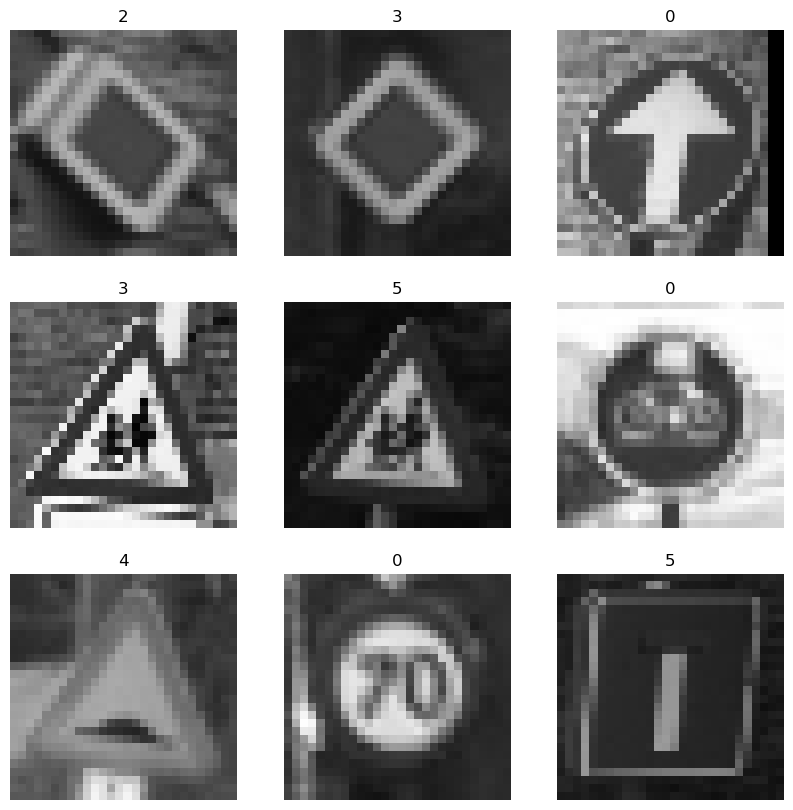

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [4]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


2024-04-26 12:49:00.815843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


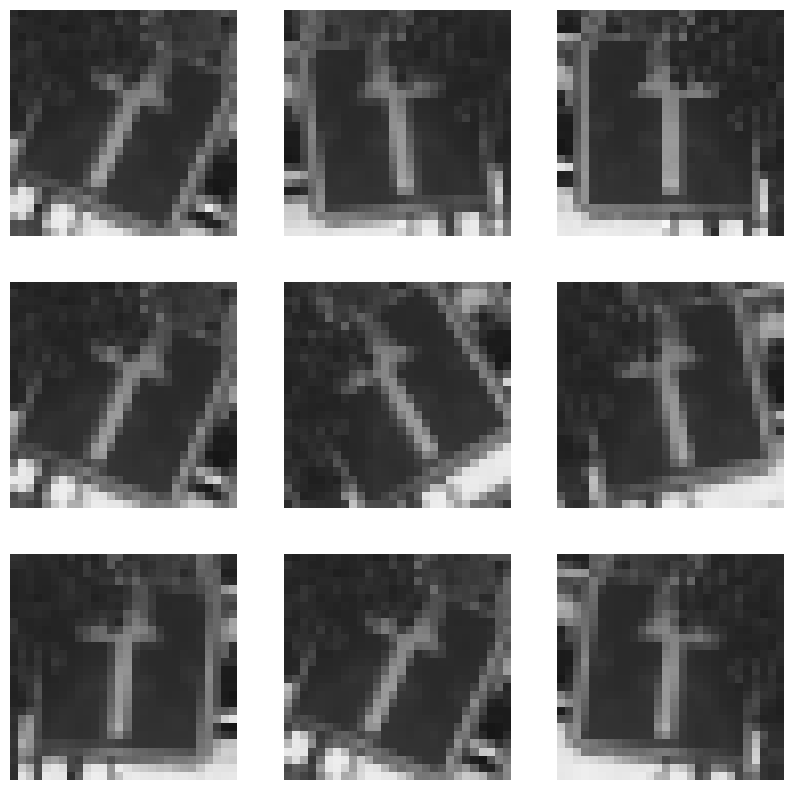

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


In [6]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(28, 1, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


AttributeError: module 'pydot' has no attribute 'InvocationException'

In [8]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 44s 199ms/step - acc: 0.0102 - loss: -35.0296 - val_acc: 0.0033 - val_loss: -16.2650
Epoch 2/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 185ms/step - acc: 0.0063 - loss: -127.9956 - val_acc: 0.0033 - val_loss: -87.9121
Epoch 3/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - acc: 0.0063 - loss: -259.0108 - val_acc: 0.0033 - val_loss: -340.1274
Epoch 4/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - acc: 0.0063 - loss: -445.6452 - val_acc: 0.0033 - val_loss: -691.3262
Epoch 5/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 193ms/step - acc: 0.0063 - loss: -679.7380 - val_acc: 0.0033 - val_loss: -914.9682
Epoch 6/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - acc: 0.0063 - loss: -950.7818 - val_acc: 0.0033 - val_loss: -1180.2421
Epoch 7/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 36s 193ms/step - acc: 0.0063 - loss: -1256.0178 - val_acc: 0.0033 - val_loss: -1472.0956
Epoch 8/25
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 204ms/step - acc: 0.0063 - loss: -1596.6533 - val_acc: 0.0033 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
This image is 0.00% bicycle and 100.00% other.


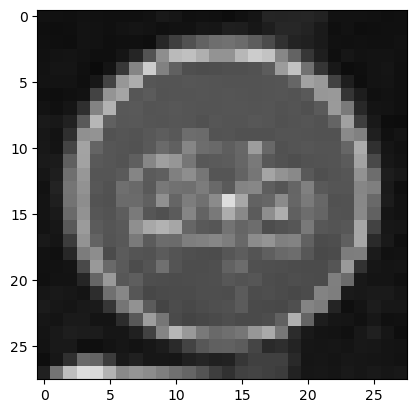

In [9]:
img = keras.utils.load_img("trafficsigns_dataset/round/bicycle/00004_00000.png", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% bicycle and {100 * score:.2f}% other.")
